In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.17.0


In [3]:
def load_data(datasets, percentage=1):
    """
    datasets: dict of dataset name and its corresponding input data and ground truth
    """
    # For every dataset path in datasets
        # Get the jpg files 
        # Sort them
        # Print "Loaded {dataset}"
        # Assert len(input_paths) == len(labels_paths)
    # Create tensor slies for the input and ground labels
    # Zip them together

    # Python list of all the paths of every input in every dataset
    input_paths = []
    gt_paths = []

    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
    
    for dataset in datasets:
        print(f"Loading in {dataset} dataset...")
        # Get the input and ground truth paths
        input_dir, gt_dir = datasets[dataset]

        # Get a python list of all the paths of the pictures
        input_path = []
        gt_path = []
        for ext in image_extensions:
            input_path.extend(tf.io.gfile.glob(os.path.join(input_dir, ext)))
            gt_path.extend(tf.io.gfile.glob(os.path.join(gt_dir, ext)))

        # Sort the files so they can be mapped correctly
        input_path = sorted(input_path)
        gt_path = sorted(gt_path)

        # Ensure that their lengths are equal
        assert len(input_path) == len(gt_path) 

        # Print the first input file and its corresponding label for confirmation
        # print(f"Input: {input_path[0]} Label: {gt_path[0]}")

        # Add the paths to input_paths to then zip up the dataset
        input_paths.extend(input_path)
        gt_paths.extend(gt_path)
        
        print("Finished Loading")

    cutoff = int(len(input_paths) * percentage)
    
    # Create tensor slices of the inputs
    ds_input = tf.data.Dataset.from_tensor_slices(input_paths[:cutoff])
    gt_path  = tf.data.Dataset.from_tensor_slices(gt_paths[:cutoff])

    # Zip up the dataset so that each image has its corresponding label
    ds = tf.data.Dataset.zip(ds_input, gt_path)

    return ds
    

In [4]:
LSUI_data_dir = "/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI"
LSUI_input_dir = f"{LSUI_data_dir}/input"
LSUI_gt_dir = f"{LSUI_data_dir}/GT"

EUVP_UNDERWATER_DARK_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark"
EUVP_UNDERWATER_DARK_input_dir = f"{EUVP_UNDERWATER_DARK_data_dir}/trainA"
EUVP_UNDERWATER_DARK_gt_dir = f"{EUVP_UNDERWATER_DARK_data_dir}/trainB"

EUVP_UNDERWATER_IMAGENET_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet"
EUVP_UNDERWATER_IMAGENET_input_dir = f"{EUVP_UNDERWATER_IMAGENET_data_dir}/trainA"
EUVP_UNDERWATER_IMAGENET_gt_dir = f"{EUVP_UNDERWATER_IMAGENET_data_dir}/trainB"

EUVP_UNDERWATER_SCENES_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes"
EUVP_UNDERWATER_SCENES_input_dir = f"{EUVP_UNDERWATER_SCENES_data_dir}/trainA"
EUVP_UNDERWATER_SCENES_gt_dir = f"{EUVP_UNDERWATER_SCENES_data_dir}/trainB"

datasets = {
    "LSUI": (LSUI_input_dir, LSUI_gt_dir),
    # "EUVP Underwater Dark": (EUVP_UNDERWATER_DARK_input_dir, EUVP_UNDERWATER_DARK_gt_dir),
    # "EUVP Underwater ImageNet": (EUVP_UNDERWATER_IMAGENET_input_dir, EUVP_UNDERWATER_IMAGENET_gt_dir)
}

ds = load_data(datasets, 1)

Loading in LSUI dataset...
Finished Loading


In [5]:
DATASET_SIZE = tf.data.experimental.cardinality(ds).numpy()
print(f"There are: {DATASET_SIZE} image pairs")

There are: 4279 image pairs


In [6]:
batch_size = 32
img_height = 128
img_width = 128

In [7]:
# Split the dataset into 80% for training and 20% for validation/dev set
val_size = int(DATASET_SIZE * 0.2)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)
print(val_size)

855


In [8]:
print(f"Training size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_ds).numpy()}")

Training size: 3424
Validation size: 855


In [9]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3, expand_animations=False)

    # Normalize the image values to be in the [0, 1] range
    input_img = tf.cast(img, tf.float32) / 255.0
    
    # Resize the image to the desired size
    return tf.image.resize(input_img, [img_height, img_width])

In [10]:
def process_path(input_path, gt_path):
    # Load the raw data from the file as a string
    input_img = tf.io.read_file(input_path)
    gt_img = tf.io.read_file(gt_path)

    input_img = decode_img(input_img)
    gt_img = decode_img(gt_img)
    return input_img, gt_img

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (128, 128, 3)
Label:  (128, 128, 3)


In [13]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [14]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [15]:
# Every batch has 32 images of shape 128x128 and 3 color channels (RGB)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32, 128, 128, 3)


In [16]:
print(f"Training dataset has: {tf.data.experimental.cardinality(train_ds).numpy()} batches")
print(f"Validation size has: {tf.data.experimental.cardinality(val_ds).numpy()} batches")

Training dataset has: 107 batches
Validation size has: 27 batches


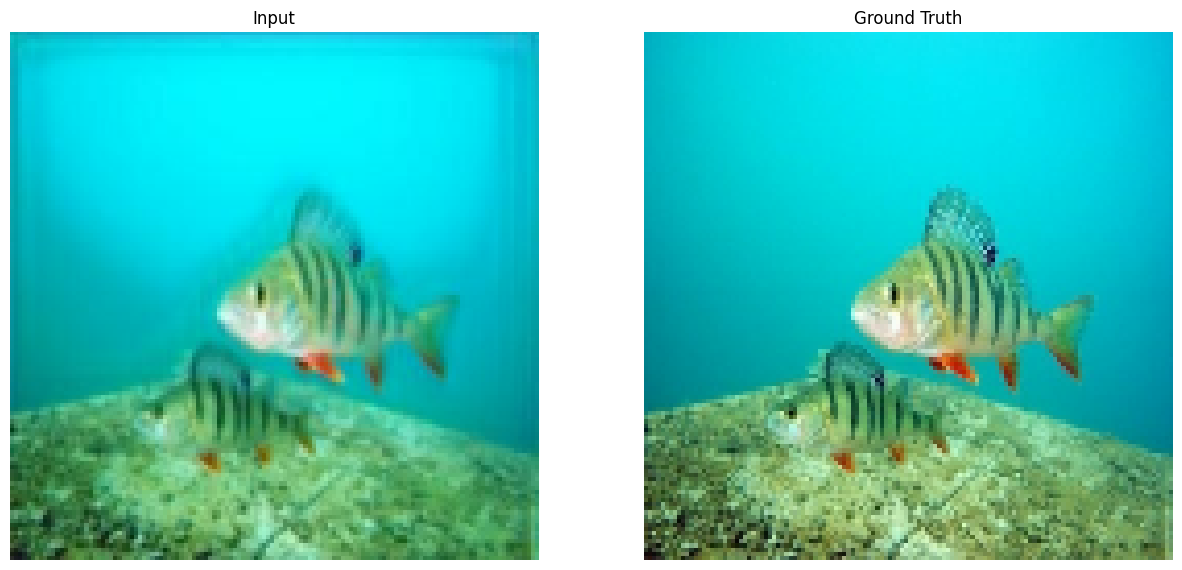

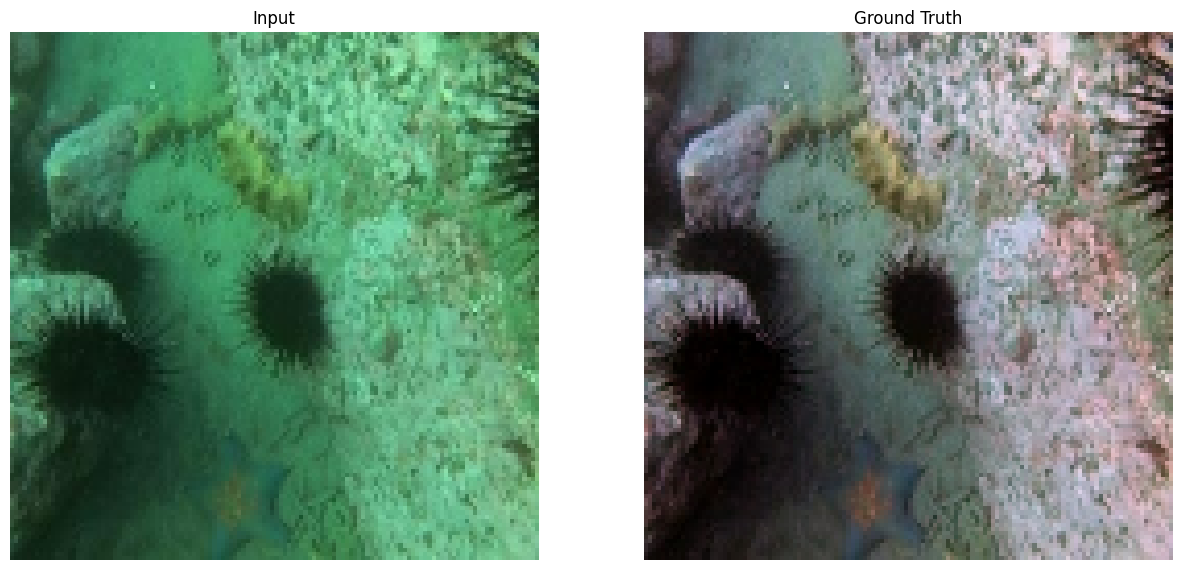

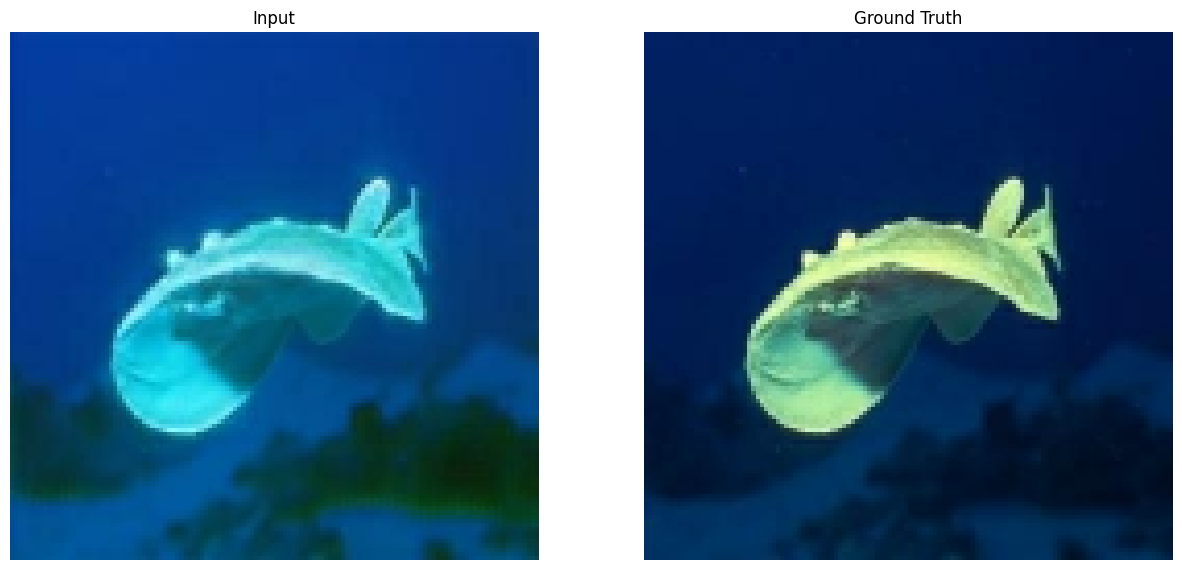

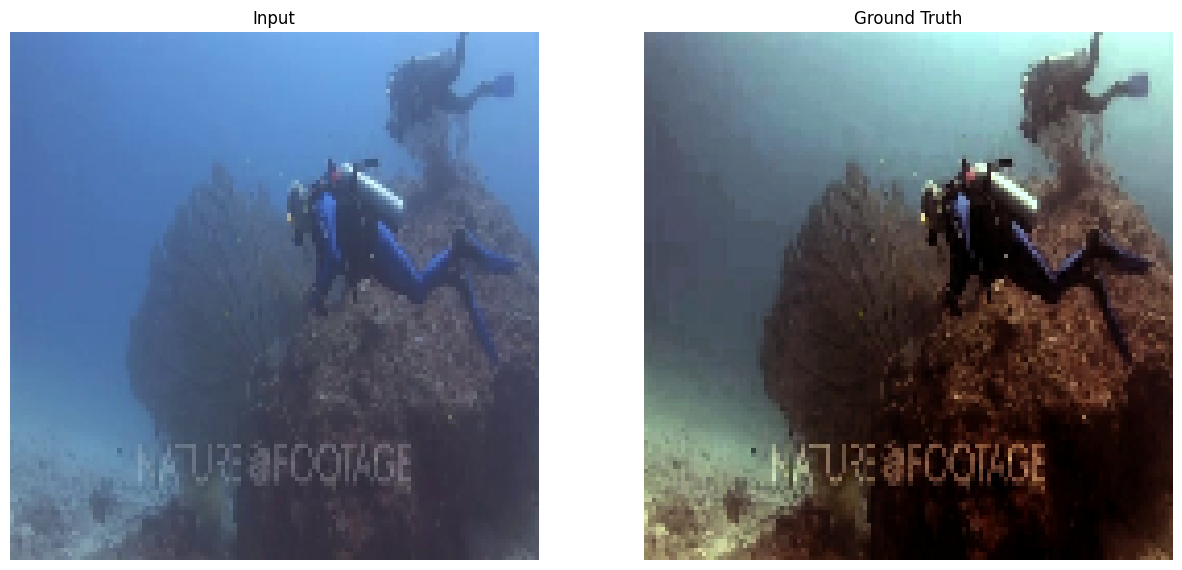

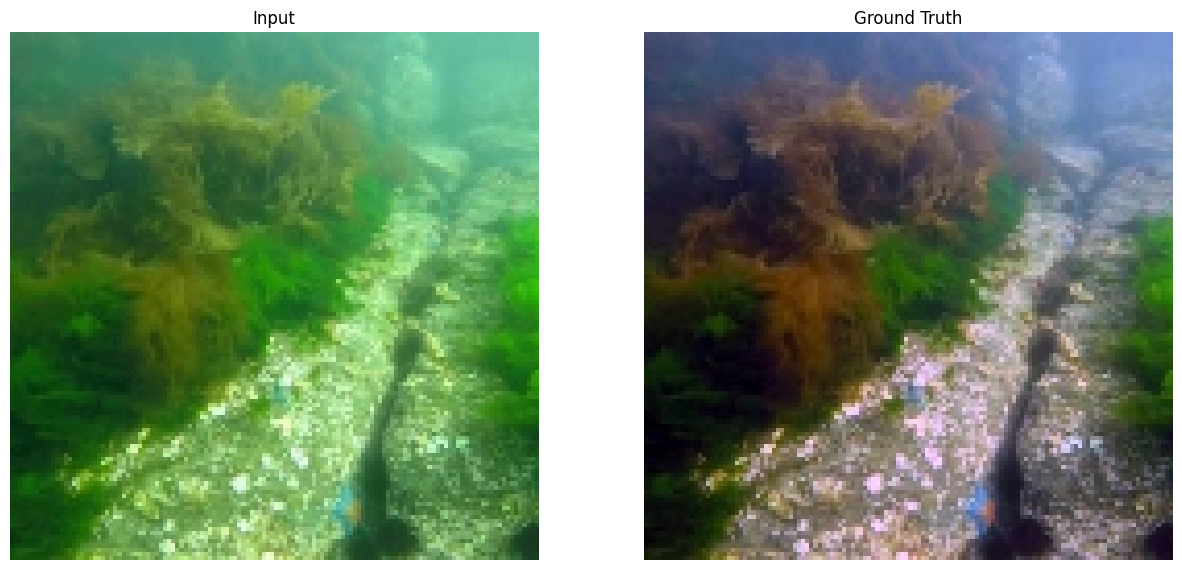

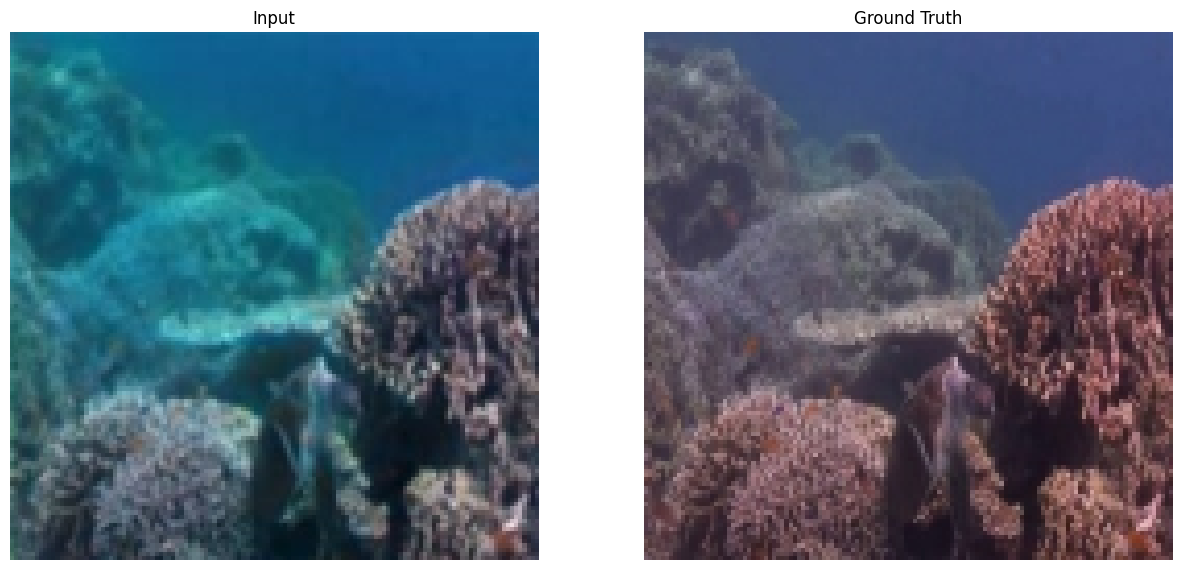

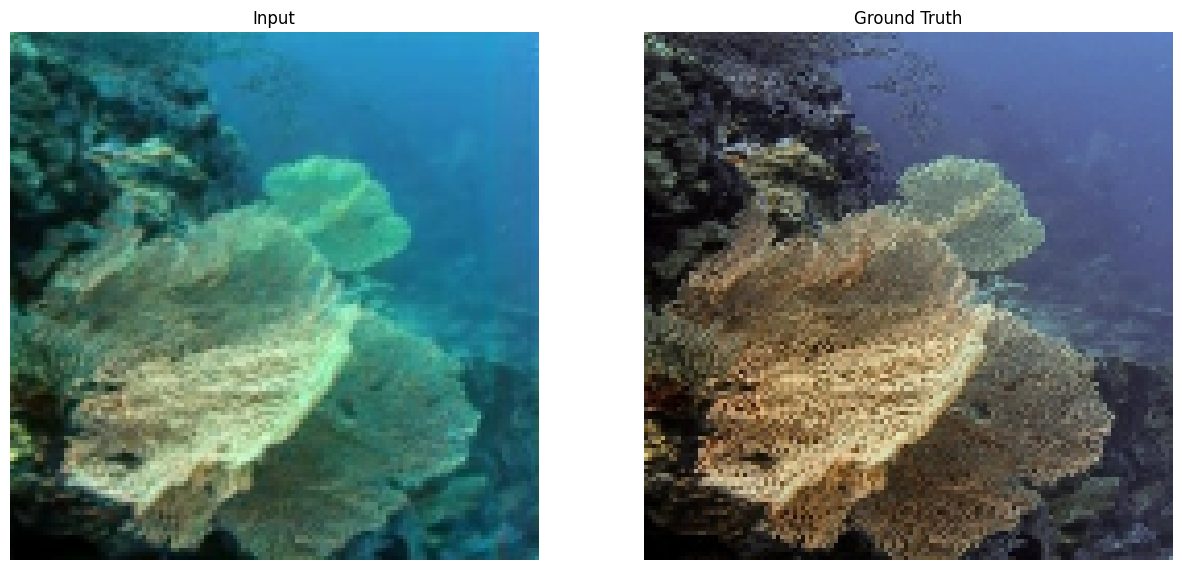

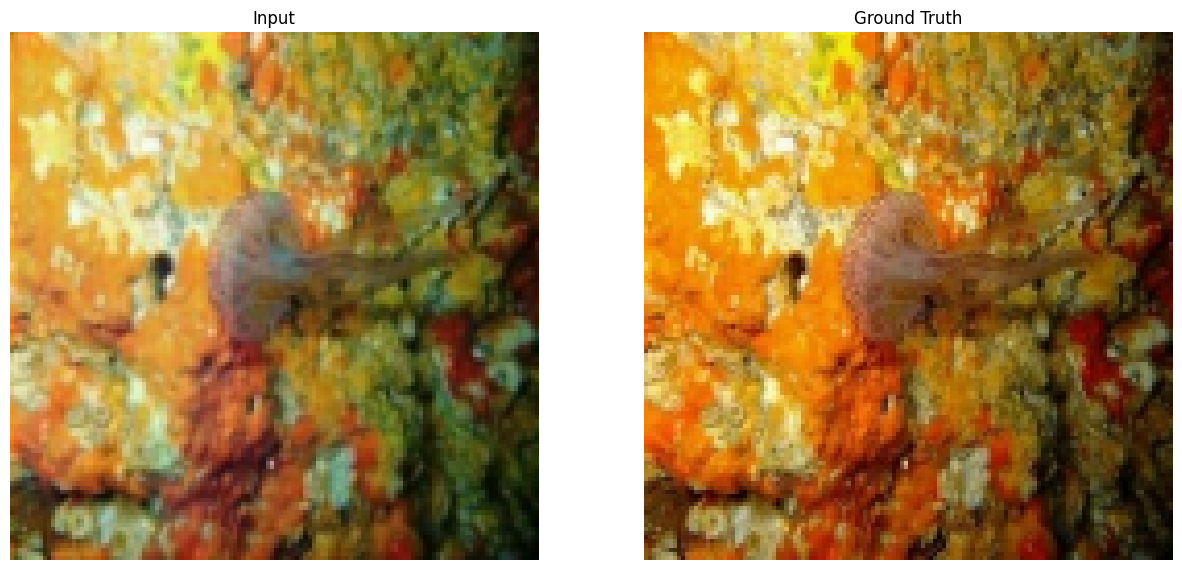

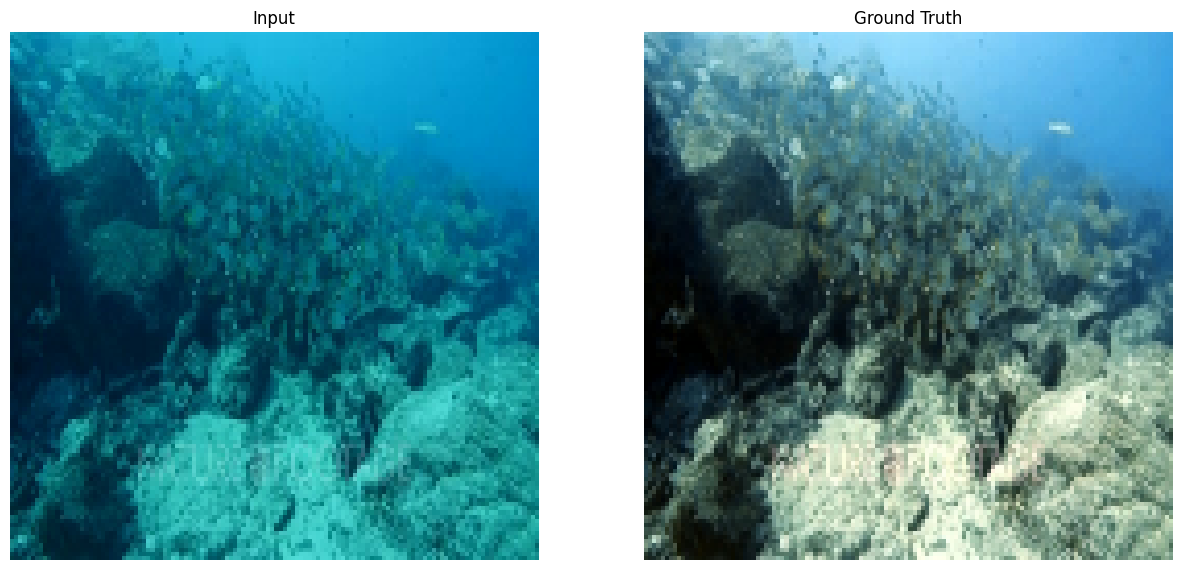

In [17]:
import matplotlib.pyplot as plt

image_batch, gt_batch = next(iter(train_ds))

for i in range(9):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))
    plt.title('Input')
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow((gt_batch[i].numpy() * 255).astype("uint8"))
    plt.title('Ground Truth')
    plt.axis("off")
    plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [19]:
class UWEnhancement(Model):
    def __init__(self):
        super(UWEnhancement, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(128, 128, 3)),

            layers.Conv2D(32, (3, 3), activation="relu", strides=1, padding="same"), # Output: 128x128x32
            layers.Conv2D(32, (3, 3), activation="relu", strides=1, padding="same"), # Output: 128x128x32

            layers.MaxPooling2D(pool_size=(2,2), strides=2), # Output: 64x64x32

            layers.Conv2D(64, (3, 3), activation="relu", strides=1, padding="same"), # Output: 64x64x32
            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"), # Output: 64x64x128

            layers.MaxPooling2D(pool_size=(2,2), strides=2), # Output: 32x32x128
            
            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"), # Output: 32x32x128
            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"), # Output: 32x32x128

            layers.MaxPooling2D(pool_size=(2,2), strides=2), # Output: 16x16x128
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same"),
            
            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"),
            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"),

            layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same"),
            
            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"),
            layers.Conv2D(64, (3, 3), activation="relu", strides=1, padding="same"),

            layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same"),

            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"),
            layers.Conv2D(128, (3, 3), activation="relu", strides=1, padding="same"),
            
            layers.Conv2D(filters=3, kernel_size=(3, 3), activation="sigmoid", padding="same")
        ])
        
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = UWEnhancement()

In [20]:
autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())

In [21]:
autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 430ms/step - loss: 0.0497 - val_loss: 0.0322
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 29s 272ms/step - loss: 0.0268 - val_loss: 0.0291
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - loss: 0.0245 - val_loss: 0.0258
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 286ms/step - loss: 0.0226 - val_loss: 0.0240
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - loss: 0.0182 - val_loss: 0.0226
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.0172 - val_loss: 0.0198
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 283ms/step - loss: 0.0156 - val_loss: 0.0198
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.0148 - val_loss: 0.0191
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.0141 - val_loss: 0.0189
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.0136 - val_loss: 0.0194


In [22]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 397,664 (1.52 MB)

 Trainable params: 397,664 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 778,499 (2.97 MB)

 Trainable params: 778,499 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import matplotlib.pyplot as plt

image_batch, gt_batch = next(iter(train_ds))

reconstructed_batch = autoencoder.predict(image_batch)
print(reconstructed_batch[0])
print(reconstructed_batch.shape)

reconstructed_batch = np.clip(reconstructed_batch * 255.0, 0, 255).astype('uint8')
print(reconstructed_batch.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
[[[0.22960138 0.30200174 0.37604237]
  [0.17697646 0.26488742 0.33534878]
  [0.14604041 0.22515634 0.29719993]
  ...
  [0.21584636 0.2544348  0.2831487 ]
  [0.22665773 0.26175654 0.28252682]
  [0.24546939 0.29075578 0.31745017]]

 [[0.19018155 0.2666985  0.31988814]
  [0.16206688 0.24682255 0.29931015]
  [0.1380396  0.21262994 0.27685386]
  ...
  [0.20095162 0.22526507 0.24050775]
  [0.20672865 0.22911114 0.24446285]
  [0.20545283 0.23762429 0.27081507]]

 [[0.17896858 0.25327936 0.3048583 ]
  [0.15274754 0.24312957 0.2928484 ]
  [0.12897013 0.21704772 0.27911732]
  ...
  [0.18484503 0.21641317 0.23257437]
  [0.18604757 0.21295339 0.22678936]
  [0.18292323 0.2113805  0.23739563]]

 ...

 [[0.2847282  0.2682257  0.2618266 ]
  [0.26155764 0.24504116 0.22408728]
  [0.2681269  0.2458911  0.2179247 ]
  ...
  [0.5408429  0.50704896 0.4190487 ]
  [0.5311578  0.5051624  0.41893798]
  [0.5235579  0.49870908 0.41608813]]

 [[0.29809457 0.29896483 0.2750904 

In [25]:
# print(len(reconstructed_batch))
reconstructed_batch[0]

array([[[ 58,  77,  95],
        [ 45,  67,  85],
        [ 37,  57,  75],
        ...,
        [ 55,  64,  72],
        [ 57,  66,  72],
        [ 62,  74,  80]],

       [[ 48,  68,  81],
        [ 41,  62,  76],
        [ 35,  54,  70],
        ...,
        [ 51,  57,  61],
        [ 52,  58,  62],
        [ 52,  60,  69]],

       [[ 45,  64,  77],
        [ 38,  61,  74],
        [ 32,  55,  71],
        ...,
        [ 47,  55,  59],
        [ 47,  54,  57],
        [ 46,  53,  60]],

       ...,

       [[ 72,  68,  66],
        [ 66,  62,  57],
        [ 68,  62,  55],
        ...,
        [137, 129, 106],
        [135, 128, 106],
        [133, 127, 106]],

       [[ 76,  76,  70],
        [ 70,  66,  59],
        [ 70,  66,  58],
        ...,
        [135, 127, 107],
        [131, 128, 109],
        [129, 127, 110]],

       [[ 87,  85,  81],
        [ 76,  72,  67],
        [ 76,  71,  64],
        ...,
        [133, 126, 106],
        [129, 127, 108],
        [128, 127, 112]]

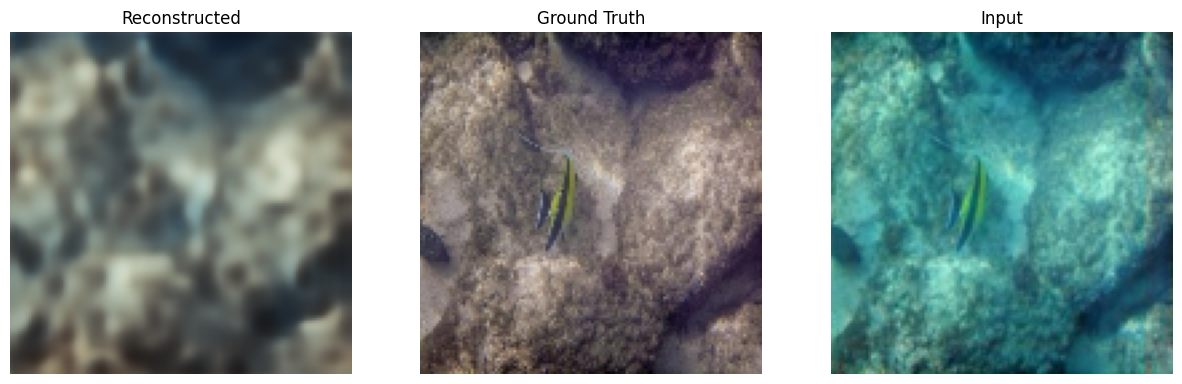

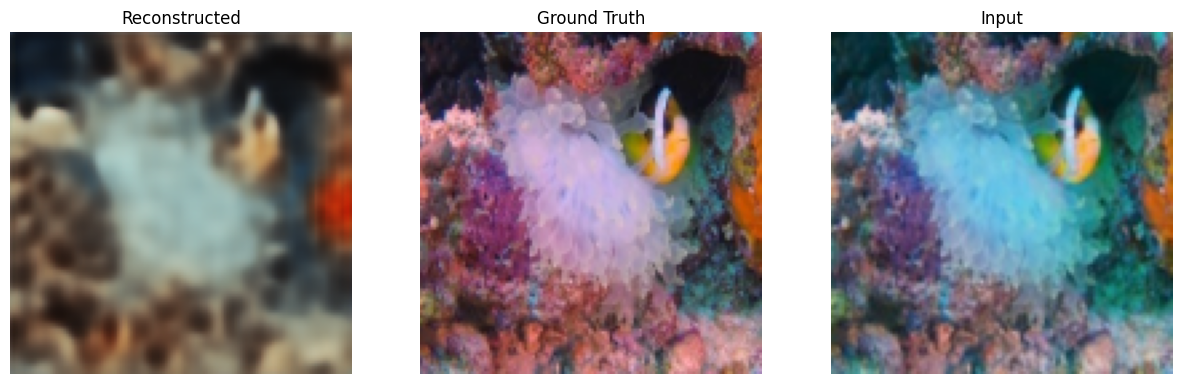

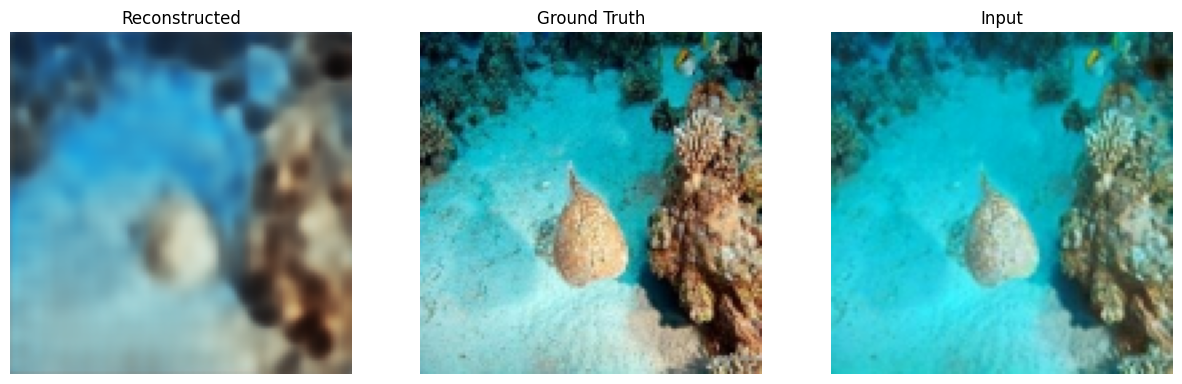

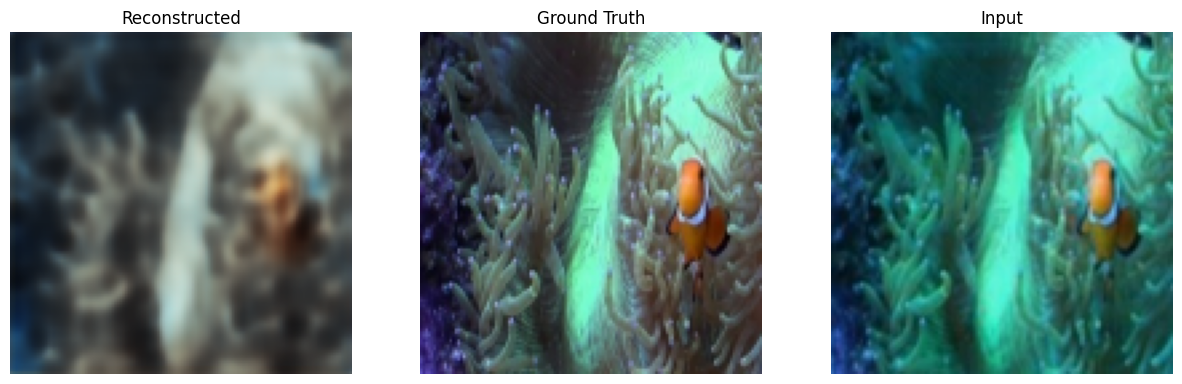

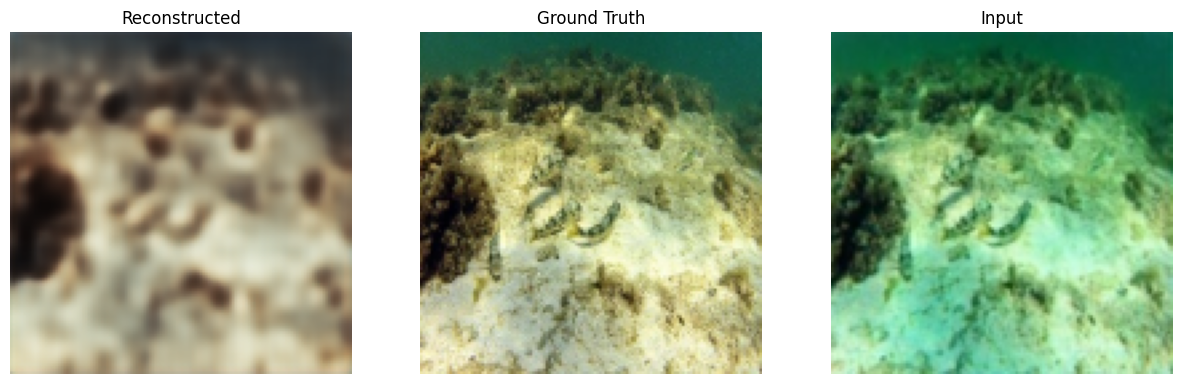

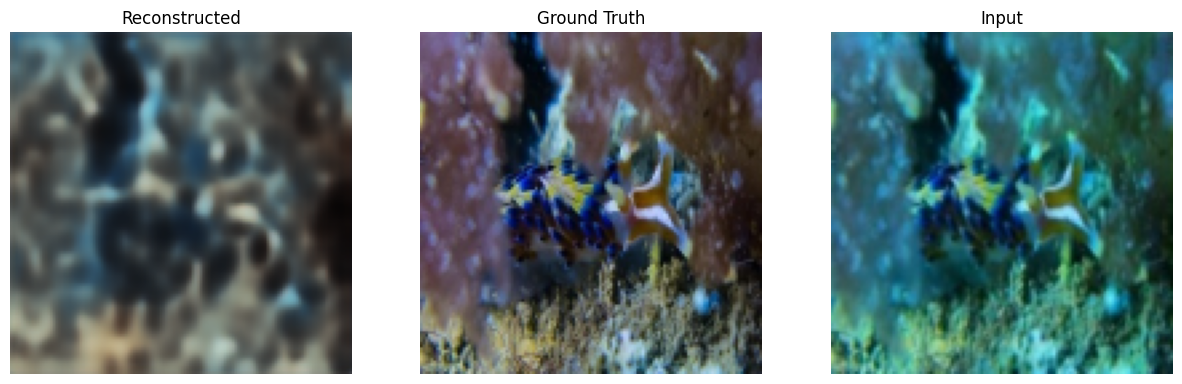

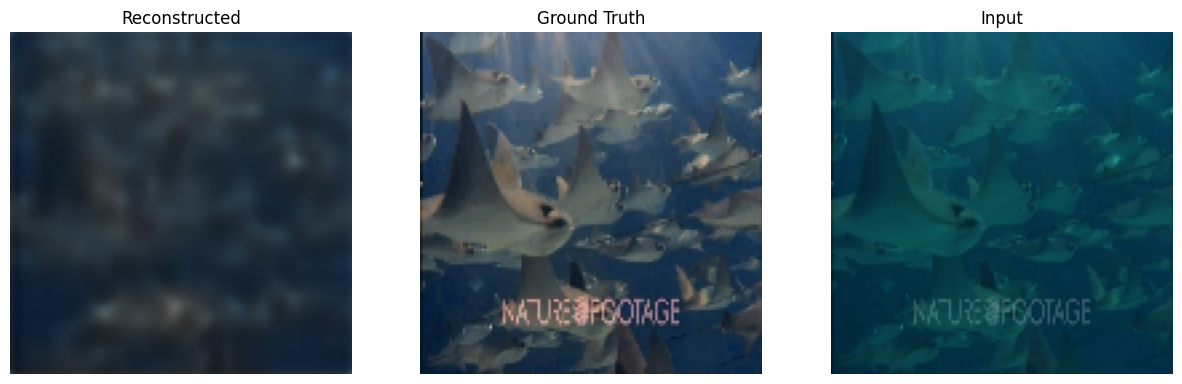

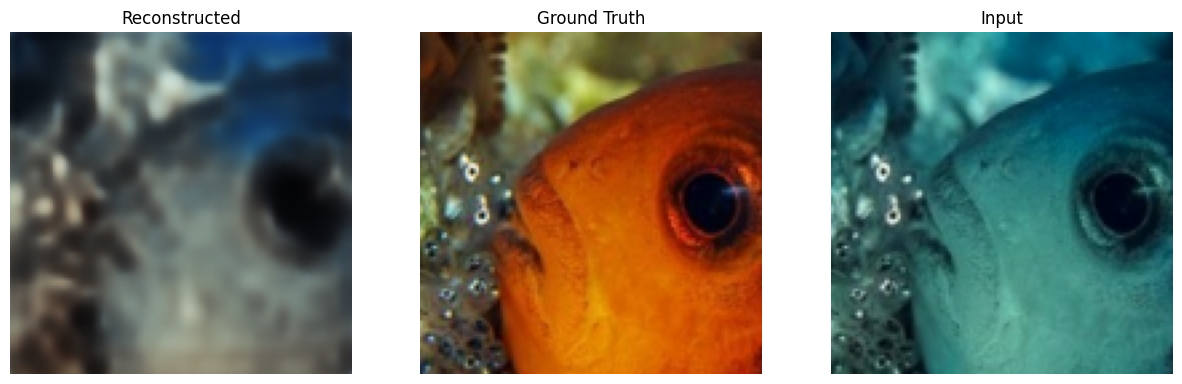

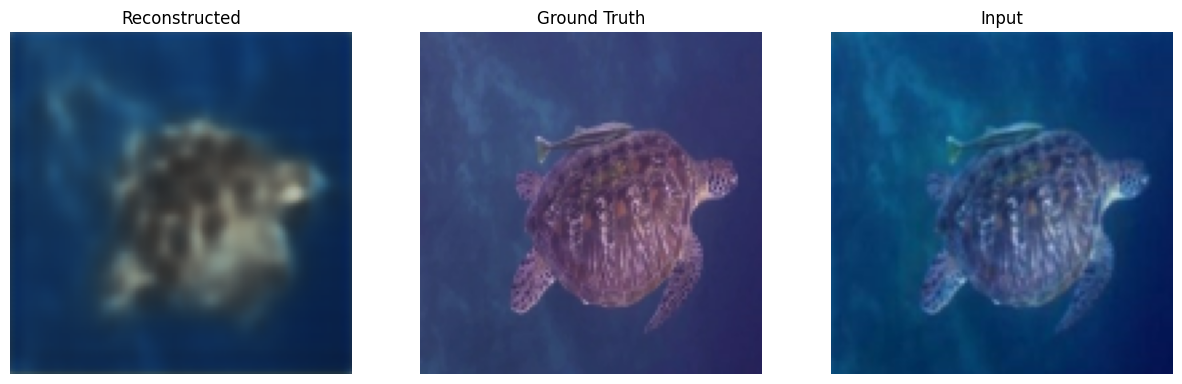

In [26]:
for i in range(9):
    plt.figure(figsize=(15, 10))
    
    # Reconstructed Image
    plt.subplot(1, 3, 1)
    plt.imshow(reconstructed_batch[i])
    plt.title('Reconstructed')
    plt.axis("off")
    
    # Ground Truth Image
    gt_image = gt_batch[i].numpy()
    gt_image = np.clip(gt_image * 255.0, 0, 255).astype("uint8")
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image)
    plt.title('Ground Truth')
    plt.axis("off")
    
    # Input Image (for reference)
    input_image = image_batch[i].numpy()
    input_image = np.clip(input_image * 255.0, 0, 255).astype("uint8")
    plt.subplot(1, 3, 3)
    plt.imshow(input_image)
    plt.title('Input')
    plt.axis("off")
    
    plt.show()
